**Νευρωνικά Δίκτυα - Βαθιά Μάθηση**

Νίκος Κιοσσές

12/2024

###Εισαγωγή Βιβλιοθηκών

In [1]:
from sklearn import svm
import torchvision
from tensorflow.keras.datasets import cifar10
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tqdm import tqdm
import pandas as pd

###Κατέβασμα, προετοιμασία και εμφάνιση δεδομένων



**Κατέβασμα δεδομένων**

In [3]:
# Φόρτωση του CIFAR-10 dataset
(x_train_original, y_train_original), (x_test_original, y_test_original) = cifar10.load_data()

**Εμφάνιση δεδομένων**

In [4]:
# Εκτύπωση των διαστάσεων
print(x_train_original.shape)
print(y_train_original.shape)
print(x_test_original.shape)
print(y_test_original.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [5]:
# CIFAR-10 class labels
class_names = [
    "Airplane", "Automobile", "Bird", "Cat", "Deer",
    "Dog", "Frog", "Horse", "Ship", "Truck"
]

for i in class_names:
  print(class_names.index(i), i)

0 Airplane
1 Automobile
2 Bird
3 Cat
4 Deer
5 Dog
6 Frog
7 Horse
8 Ship
9 Truck


In [6]:
# Εκτύπωση του διανύσματος της πρώτης εικόνας του train set
print(x_train_original[0])
print("-----------------------------")
# Εκτύπωση του αριθμού της κλάσης της εικόνας
print(y_train_original[0])

[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]
-----------------------------
[6]


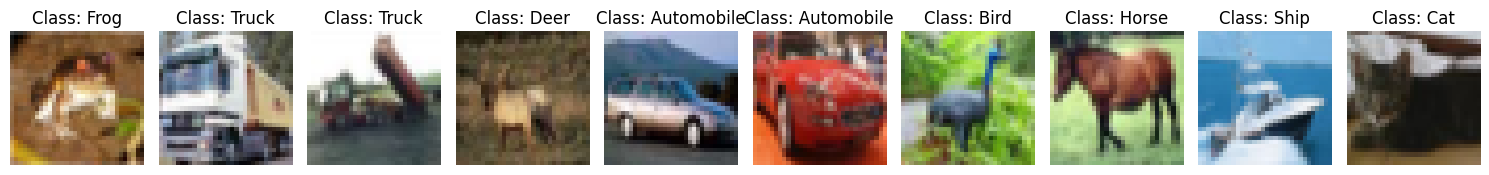

In [7]:
# Εμφάνιση των πρώτων 10 πρώτων εικόνων του x_train_original
num_images = 10

plt.figure(figsize=(15, 5))
for i in range(num_images):
    image = x_train_original[i].reshape(32, 32, 3)
    plt.subplot(1, num_images, i + 1)
    plt.imshow(image.astype('uint8'))
    plt.title(f"Class: {class_names[y_train_original[i][0]]}")
    plt.axis('off')
plt.tight_layout()

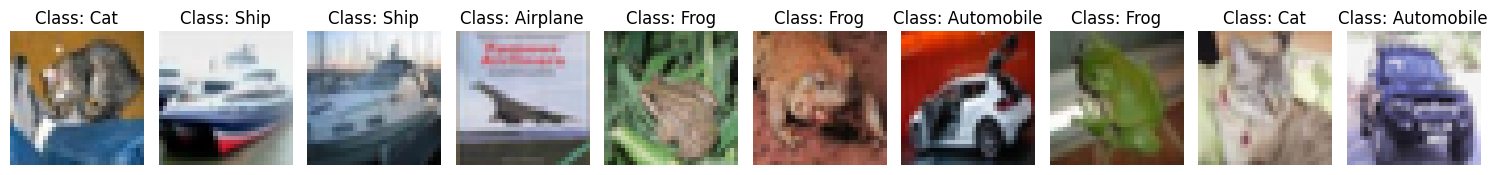

In [8]:
# Εμφάνιση των πρώτων 10 πρώτων εικόνων του x_test_original
num_images = 10

plt.figure(figsize=(15, 5))
for i in range(num_images):
    image = x_test_original[i].reshape(32, 32, 3)
    plt.subplot(1, num_images, i + 1)
    plt.imshow(image.astype('uint8'))
    plt.title(f"Class: {class_names[y_test_original[i][0]]}")
    plt.axis('off')
plt.tight_layout()

In [9]:
x_train = x_train_original
y_train = y_train_original
x_test = x_test_original
y_test = y_test_original

**Data augmentation**

In [9]:
# Δημιουργία generator για data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,             # Περιστροφή έως και 15 μοίρες
    width_shift_range=0.1,         # Οριζόντια μετατόπιση έως 10%
    height_shift_range=0.1,        # Κάθετη μετατόπιση έως 10%
    horizontal_flip=True,          # Οριζόντια αναστροφή
    brightness_range=[0.8, 1.2],   # Τυχαία φωτεινότητα
    zoom_range=0.2                 # Τυχαίο zoom έως 20%
)

# Εφαρμογή augmentation στο train set
augmented_images = []
augmented_labels = []

# Δημιουργία augmented set με ίδιο μέγεθος με το αρχικό
for x_batch, y_batch in datagen.flow(x_train_original, y_train_original, batch_size=len(x_train_original), seed=42):
    augmented_images = x_batch
    augmented_labels = y_batch
    break  # Σταματάμε μόλις δημιουργηθεί ένα augmented set με το ίδιο μέγεθος

# Επαναφορά των augmented_labels σε μονοδιάστατο διάνυσμα
augmented_labels = augmented_labels.reshape(-1, 1)

# Συνδυασμός των αρχικών δεδομένων με τα augmented
x_train = np.vstack([x_train_original, augmented_images])
y_train = np.vstack([y_train_original, augmented_labels])

print(x_train.shape)
print(y_train.shape)

(100000, 32, 32, 3)
(100000, 1)


In [10]:
print(augmented_images.shape)
print(augmented_labels.shape)

(50000, 32, 32, 3)
(50000, 1)


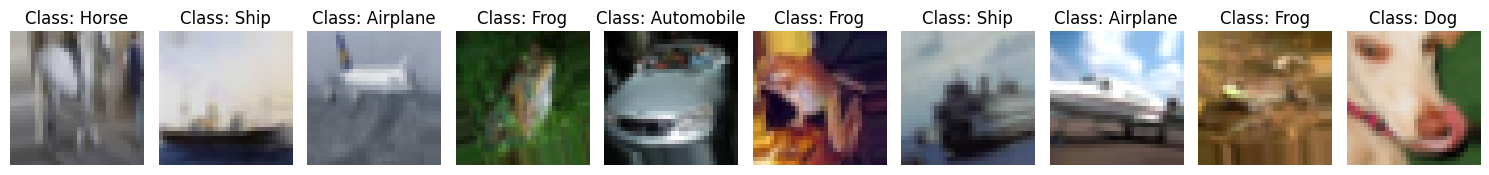

In [11]:
# Εμφάνιση των πρώτων 10 πρώτων εικόνων του augmented_images
num_images = 10

plt.figure(figsize=(15, 5))
for i in range(num_images):
    image = augmented_images[i].reshape(32, 32, 3)
    plt.subplot(1, num_images, i + 1)
    plt.imshow(image.astype('uint8'))
    plt.title(f"Class: {class_names[augmented_labels[i][0]]}")
    plt.axis('off')
plt.tight_layout()

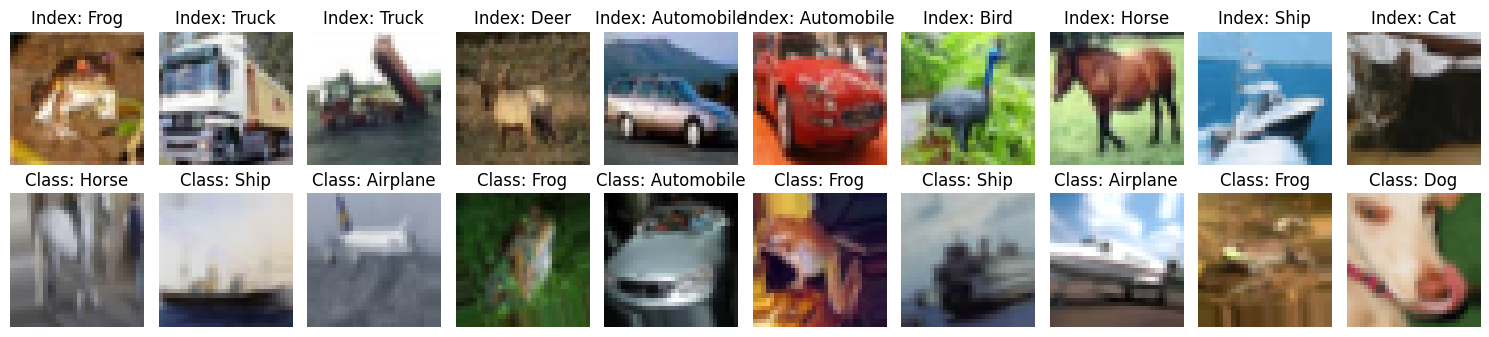

In [12]:
# Εικόνες του x_train μετά το data augmentation
num_images = 10
index = -1
plt.figure(figsize=(15, 5))
for i in range(num_images):
    index += 1

    image = x_train[index].reshape(32, 32, 3)
    plt.subplot(3, num_images, i + 1)
    plt.imshow(image.astype('uint8'))
    plt.title(f"Index: {class_names[y_train[index][0]]}")
    plt.axis('off')

    image = x_train[index+50000].reshape(32, 32, 3)
    plt.subplot(1, num_images, i + 1)
    plt.imshow(image.astype('uint8'))
    plt.title(f"Class: {class_names[y_train[index+50000][0]]}")
    plt.axis('off')

plt.tight_layout()

**Flatten**

In [10]:
# Μετατροπή των x_train και x_test σε μονοδιάστατους πίνακες
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

print(x_train.shape)
print(x_test.shape)

(50000, 3072)
(10000, 3072)


In [11]:
# Εκτύπωση του διανύσματος της πρώτης εικόνας του train set
print(x_train[0])
print("-----------------------------")
# Εκτύπωση του αριθμού της κλάσης της εικόνας
print(y_train[0])

[ 59  62  63 ... 123  92  72]
-----------------------------
[6]


**PCA**

In [12]:
# Χρήση PCA με διατήρηση του 90% των συνιστωσών
pca = PCA(n_components=0.9)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

print(x_train.shape)
print(x_test.shape)

(50000, 99)
(10000, 99)


**Κανονικοποίηση δεδομένων**

In [13]:
# Κανονικοποίηση δεδομένων ώστε κάθε χαρακτηριστικό (κάθε στήλη) να έχει Μέση τιμή (mean) = 0 και Τυπική απόκλιση (std) = 1
# x' = (x - mean) / std
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

###SVM με linear kernel

####Εκπαίδευση SVM μετά από Cross Validation

**Δημιουργία SVM**

In [ ]:
svm_poly_kernel = svm.SVC(kernel='linear')

**Cross Validation για εύρεση βέλτιστων παραμέτρων**

In [ ]:
# Ορισμός του πλέγματος υπερπαραμέτρων για το C
param_grid = {'C': [1, 10, 30, 50, 100]}

# GridSearchCV με Cross Validation
grid_search = GridSearchCV(svm_poly_kernel, param_grid, cv=4, verbose=2, n_jobs=-1)

**Εκπαίδευση SVM με τις βέλτιστες παραμέτρους**

In [ ]:
start_time = time.time()

# Εκπαίδευση polynomial SVM με grid_search
grid_search.fit(x_train, y_train.ravel())

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time} seconds")

# Εκτύπωση των καλύτερων παραμέτρων
print("Best parameters found: ", grid_search.best_params_)

**Αξιολόγηση στα δεδομένα του test set.**

In [ ]:
# Πρόβλεψη στα δείγματα του test set
y_pred = grid_search.best_estimator_.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Εκτύπωση μετρικών
print(f'Accuracy: {100 * accuracy:.2f}%')
print(f'Precision: {100 * precision:.2f}%')
print(f'Recall: {100 * recall:.2f}%')
print(f'F1 Score: {100 * f1:.2f}%')

In [ ]:
# Δημιουργία DataFrame με στήλη που δείχνει αν η πρόβλεψη είναι σωστή
results_df = pd.DataFrame({
    'True Labels': y_test.ravel(),
    'Predicted Labels': y_pred
})
results_df['Correct'] = results_df['True Labels'] == results_df['Predicted Labels']

# Στυλ για highlight
def highlight_correct(row):
    if row['Correct']:
        return ['background-color: lightgreen'] * len(row)
    else:
        return ['background-color: lightcoral'] * len(row)

# Εφαρμογή highlight στο DataFrame
styled_df = results_df.style.apply(highlight_correct, axis=1)

# Εμφάνιση των πρώτων 10 γραμμών
print(results_df.head(10))

**Αξιολόγηση στα δεδομένα του train set.**

In [ ]:
# Πρόβλεψη στα δείγματα του train set
y_pred = grid_search.best_estimator_.predict(x_train)

accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
recall = recall_score(y_train, y_pred, average='weighted')
f1 = f1_score(y_train, y_pred, average='weighted')

# Εκτύπωση μετρικών
print(f'Accuracy: {100 * accuracy:.2f}%')
print(f'Precision: {100 * precision:.2f}%')
print(f'Recall: {100 * recall:.2f}%')
print(f'F1 Score: {100 * f1:.2f}%')

In [ ]:
# Δημιουργία DataFrame με στήλη που δείχνει αν η πρόβλεψη είναι σωστή
results_df = pd.DataFrame({
    'True Labels': y_train.ravel(),
    'Predicted Labels': y_pred
})
results_df['Correct'] = results_df['True Labels'] == results_df['Predicted Labels']

# Στυλ για highlight
def highlight_correct(row):
    if row['Correct']:
        return ['background-color: lightgreen'] * len(row)
    else:
        return ['background-color: lightcoral'] * len(row)

# Εφαρμογή highlight στο DataFrame
styled_df = results_df.style.apply(highlight_correct, axis=1)

# Εμφάνιση των πρώτων 10 γραμμών
print(results_df.head(10))

####Εκπαίδευση SVM με απλό ορισμό παραμέτρων

**Δημιουργία SVM**

In [14]:
svm_linear_kernel = svm.SVC(kernel='linear', C=1)

**Εκπαίδευση SVM**

In [15]:
start_time = time.time()

# Εκπαίδευση SVM με linear kernel
svm_linear_kernel.fit(x_train, y_train.ravel())

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time} seconds")

Training time: 1785.4973723888397 seconds


**Αξιολόγηση στα δεδομένα του test set.**

In [16]:
# Πρόβλεψη στα δείγματα του test set
y_pred = svm_linear_kernel.predict(x_test)

accuracy = accuracy_score(y_test_original, y_pred)
precision = precision_score(y_test_original, y_pred, average='weighted')
recall = recall_score(y_test_original, y_pred, average='weighted')
f1 = f1_score(y_test_original, y_pred, average='weighted')

# Εκτύπωση μετρικών
print(f'Accuracy: {100 * accuracy:.2f}%')
print(f'Precision: {100 * precision:.2f}%')
print(f'Recall: {100 * recall:.2f}%')
print(f'F1 Score: {100 * f1:.2f}%')

Accuracy: 40.79%
Precision: 40.52%
Recall: 40.79%
F1 Score: 40.54%


In [17]:
# Δημιουργία DataFrame με στήλη που δείχνει αν η πρόβλεψη είναι σωστή
results_df = pd.DataFrame({
    'True Labels': y_test_original.ravel(),
    'Predicted Labels': y_pred
})
results_df['Correct'] = results_df['True Labels'] == results_df['Predicted Labels']

# Στυλ για highlight
def highlight_correct(row):
    if row['Correct']:
        return ['background-color: lightgreen'] * len(row)
    else:
        return ['background-color: lightcoral'] * len(row)

# Εφαρμογή highlight στο DataFrame
styled_df = results_df.style.apply(highlight_correct, axis=1)

# Εμφάνιση των πρώτων 10 γραμμών
print(results_df.head(10))

   True Labels  Predicted Labels  Correct
0            3                 3     True
1            8                 9    False
2            8                 8     True
3            0                 8    False
4            6                 4    False
5            6                 6     True
6            1                 3    False
7            6                 6     True
8            3                 2    False
9            1                 1     True


**Αξιολόγηση στα δεδομένα του train set.**


In [18]:
# Πρόβλεψη στα δείγματα του train set
y_pred = svm_linear_kernel.predict(x_train)

accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
recall = recall_score(y_train, y_pred, average='weighted')
f1 = f1_score(y_train, y_pred, average='weighted')

# Εκτύπωση μετρικών
print(f'Accuracy: {100 * accuracy:.2f}%')
print(f'Precision: {100 * precision:.2f}%')
print(f'Recall: {100 * recall:.2f}%')
print(f'F1 Score: {100 * f1:.2f}%')

Accuracy: 42.03%
Precision: 41.75%
Recall: 42.03%
F1 Score: 41.75%


In [19]:
# Δημιουργία DataFrame με στήλη που δείχνει αν η πρόβλεψη είναι σωστή
results_df = pd.DataFrame({
    'True Labels': y_train.ravel(),
    'Predicted Labels': y_pred
})
results_df['Correct'] = results_df['True Labels'] == results_df['Predicted Labels']

# Στυλ για highlight
def highlight_correct(row):
    if row['Correct']:
        return ['background-color: lightgreen'] * len(row)
    else:
        return ['background-color: lightcoral'] * len(row)

# Εφαρμογή highlight στο DataFrame
styled_df = results_df.style.apply(highlight_correct, axis=1)

# Εμφάνιση των πρώτων 10 γραμμών
print(results_df.head(10))

   True Labels  Predicted Labels  Correct
0            6                 6     True
1            9                 1    False
2            9                 9     True
3            4                 6    False
4            1                 9    False
5            1                 7    False
6            2                 2     True
7            7                 7     True
8            8                 8     True
9            3                 7    False


###SVM με polynomial kernel

####Εκπαίδευση SVM μετά από Cross Validation

**Δημιουργία SVM**

In [ ]:
svm_poly_kernel = svm.SVC(kernel='poly')

**Cross Validation για εύρεση βέλτιστων παραμέτρων**

In [ ]:
# Ορισμός του πλέγματος υπερπαραμέτρων για το C και το degree
param_grid = {'C': [10, 30, 50], 'degree': [2, 3, 4]}

# GridSearchCV με Cross Validation
grid_search = GridSearchCV(svm_poly_kernel, param_grid, cv=4, verbose=2, n_jobs=-1)

**Εκπαίδευση SVM με τις βέλτιστες παραμέτρους**

In [ ]:
start_time = time.time()

# Εκπαίδευση polynomial SVM με grid_search
grid_search.fit(x_train, y_train.ravel())

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time} seconds")

# Εκτύπωση των καλύτερων παραμέτρων
print("Best parameters found: ", grid_search.best_params_)

**Αξιολόγηση στα δεδομένα του test set.**

In [ ]:
# Πρόβλεψη στα δείγματα του test set
y_pred = grid_search.best_estimator_.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Εκτύπωση μετρικών
print(f'Accuracy: {100 * accuracy:.2f}%')
print(f'Precision: {100 * precision:.2f}%')
print(f'Recall: {100 * recall:.2f}%')
print(f'F1 Score: {100 * f1:.2f}%')

In [ ]:
# Δημιουργία DataFrame με στήλη που δείχνει αν η πρόβλεψη είναι σωστή
results_df = pd.DataFrame({
    'True Labels': y_test.ravel(),
    'Predicted Labels': y_pred
})
results_df['Correct'] = results_df['True Labels'] == results_df['Predicted Labels']

# Στυλ για highlight
def highlight_correct(row):
    if row['Correct']:
        return ['background-color: lightgreen'] * len(row)
    else:
        return ['background-color: lightcoral'] * len(row)

# Εφαρμογή highlight στο DataFrame
styled_df = results_df.style.apply(highlight_correct, axis=1)

# Εμφάνιση των πρώτων 10 γραμμών
print(results_df.head(10))

**Αξιολόγηση στα δεδομένα του train set.**

In [ ]:
# Πρόβλεψη στα δείγματα του train set
y_pred = grid_search.best_estimator_.predict(x_train)

accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
recall = recall_score(y_train, y_pred, average='weighted')
f1 = f1_score(y_train, y_pred, average='weighted')

# Εκτύπωση μετρικών
print(f'Accuracy: {100 * accuracy:.2f}%')
print(f'Precision: {100 * precision:.2f}%')
print(f'Recall: {100 * recall:.2f}%')
print(f'F1 Score: {100 * f1:.2f}%')

In [ ]:
# Δημιουργία DataFrame με στήλη που δείχνει αν η πρόβλεψη είναι σωστή
results_df = pd.DataFrame({
    'True Labels': y_train.ravel(),
    'Predicted Labels': y_pred
})
results_df['Correct'] = results_df['True Labels'] == results_df['Predicted Labels']

# Στυλ για highlight
def highlight_correct(row):
    if row['Correct']:
        return ['background-color: lightgreen'] * len(row)
    else:
        return ['background-color: lightcoral'] * len(row)

# Εφαρμογή highlight στο DataFrame
styled_df = results_df.style.apply(highlight_correct, axis=1)

# Εμφάνιση των πρώτων 10 γραμμών
print(results_df.head(10))

####Εκπαίδευση SVM με απλό ορισμό παραμέτρων

**Δημιουργία SVM**

In [ ]:
svm_poly_kernel = svm.SVC(kernel='poly', C=30, degree=3)

**Εκπαίδευση SVM**

In [ ]:
start_time = time.time()

# Εκπαίδευση SVM με polynomial kernel
svm_poly_kernel.fit(x_train, y_train.ravel())

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time} seconds")

Training time: 9710.981819868088 seconds


**Αξιολόγηση στα δεδομένα του test set.**

In [ ]:
# Πρόβλεψη στα δείγματα του test set
y_pred = svm_poly_kernel.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Εκτύπωση μετρικών
print(f'Accuracy: {100 * accuracy:.2f}%')
print(f'Precision: {100 * precision:.2f}%')
print(f'Recall: {100 * recall:.2f}%')
print(f'F1 Score: {100 * f1:.2f}%')

Accuracy: 48.75%
Precision: 48.88%
Recall: 48.75%
F1 Score: 48.49%


In [ ]:
# Δημιουργία DataFrame με στήλη που δείχνει αν η πρόβλεψη είναι σωστή
results_df = pd.DataFrame({
    'True Labels': y_test.ravel(),
    'Predicted Labels': y_pred
})
results_df['Correct'] = results_df['True Labels'] == results_df['Predicted Labels']

# Στυλ για highlight
def highlight_correct(row):
    if row['Correct']:
        return ['background-color: lightgreen'] * len(row)
    else:
        return ['background-color: lightcoral'] * len(row)

# Εφαρμογή highlight στο DataFrame
styled_df = results_df.style.apply(highlight_correct, axis=1)

# Εμφάνιση των πρώτων 10 γραμμών
print(results_df.head(10))
#styled_df

   True Labels  Predicted Labels  Correct
0            3                 6    False
1            8                 1    False
2            8                 8     True
3            0                 0     True
4            6                 4    False
5            6                 6     True
6            1                 1     True
7            6                 6     True
8            3                 4    False
9            1                 1     True


**Αξιολόγηση στα δεδομένα του train set.**

In [ ]:
# Πρόβλεψη στα δείγματα του train set
y_pred = svm_poly_kernel.predict(x_train)

accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
recall = recall_score(y_train, y_pred, average='weighted')
f1 = f1_score(y_train, y_pred, average='weighted')

# Εκτύπωση μετρικών
print(f'Accuracy: {100 * accuracy:.2f}%')
print(f'Precision: {100 * precision:.2f}%')
print(f'Recall: {100 * recall:.2f}%')
print(f'F1 Score: {100 * f1:.2f}%')

Accuracy: 98.66%
Precision: 98.71%
Recall: 98.66%
F1 Score: 98.67%


In [ ]:
# Δημιουργία DataFrame με στήλη που δείχνει αν η πρόβλεψη είναι σωστή
results_df = pd.DataFrame({
    'True Labels': y_train.ravel(),
    'Predicted Labels': y_pred
})
results_df['Correct'] = results_df['True Labels'] == results_df['Predicted Labels']

# Στυλ για highlight
def highlight_correct(row):
    if row['Correct']:
        return ['background-color: lightgreen'] * len(row)
    else:
        return ['background-color: lightcoral'] * len(row)

# Εφαρμογή highlight στο DataFrame
styled_df = results_df.style.apply(highlight_correct, axis=1)

# Εμφάνιση των πρώτων 10 γραμμών
print(results_df.head(10))
#styled_df

   True Labels  Predicted Labels  Correct
0            6                 6     True
1            9                 9     True
2            9                 9     True
3            4                 4     True
4            1                 1     True
5            1                 1     True
6            2                 2     True
7            7                 7     True
8            8                 8     True
9            3                 3     True


###SVM με sigmoid kernel

**Δημιουργία SVM**

In [ ]:
svm_sigmoid_kernel = svm.SVC(kernel='sigmoid', C=1, gamma='scale')

**Εκπαίδευση SVM**

In [ ]:
start_time = time.time()

# Εκπαίδευση SVM με polynomial kernel
svm_sigmoid_kernel.fit(x_train, y_train.ravel())

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time} seconds")

**Αξιολόγηση στα δεδομένα του test set.**

In [ ]:
# Πρόβλεψη στα δείγματα του test set
y_pred = svm_sigmoid_kernel.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Εκτύπωση μετρικών
print(f'Accuracy: {100 * accuracy:.2f}%')
print(f'Precision: {100 * precision:.2f}%')
print(f'Recall: {100 * recall:.2f}%')
print(f'F1 Score: {100 * f1:.2f}%')

In [ ]:
# Δημιουργία DataFrame με στήλη που δείχνει αν η πρόβλεψη είναι σωστή
results_df = pd.DataFrame({
    'True Labels': y_test.ravel(),
    'Predicted Labels': y_pred
})
results_df['Correct'] = results_df['True Labels'] == results_df['Predicted Labels']

# Στυλ για highlight
def highlight_correct(row):
    if row['Correct']:
        return ['background-color: lightgreen'] * len(row)
    else:
        return ['background-color: lightcoral'] * len(row)

# Εφαρμογή highlight στο DataFrame
styled_df = results_df.style.apply(highlight_correct, axis=1)

# Εμφάνιση των πρώτων 10 γραμμών
print(results_df.head(10))

**Αξιολόγηση στα δεδομένα του train set.**

In [ ]:
# Πρόβλεψη στα δείγματα του train set
y_pred = svm_sigmoid_kernel.predict(x_train)

accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
recall = recall_score(y_train, y_pred, average='weighted')
f1 = f1_score(y_train, y_pred, average='weighted')

# Εκτύπωση μετρικών
print(f'Accuracy: {100 * accuracy:.2f}%')
print(f'Precision: {100 * precision:.2f}%')
print(f'Recall: {100 * recall:.2f}%')
print(f'F1 Score: {100 * f1:.2f}%')

In [ ]:
# Δημιουργία DataFrame με στήλη που δείχνει αν η πρόβλεψη είναι σωστή
results_df = pd.DataFrame({
    'True Labels': y_train.ravel(),
    'Predicted Labels': y_pred
})
results_df['Correct'] = results_df['True Labels'] == results_df['Predicted Labels']

# Στυλ για highlight
def highlight_correct(row):
    if row['Correct']:
        return ['background-color: lightgreen'] * len(row)
    else:
        return ['background-color: lightcoral'] * len(row)

# Εφαρμογή highlight στο DataFrame
styled_df = results_df.style.apply(highlight_correct, axis=1)

# Εμφάνιση των πρώτων 10 γραμμών
print(results_df.head(10))

###SVM με RBF kernel

####Εκπαίδευση SVM μετά από Cross Validation

**Δημιουργία SVM**

In [ ]:
svm_rbf_kernel = svm.SVC(kernel='rbf')

**Cross Validation για εύρεση βέλτιστων παραμέτρων**

In [ ]:
# Ορισμός του πλέγματος υπερπαραμέτρων για το C και το gamma
param_grid = {'C': [10, 30, 50], 'gamma':[1e-3, 1e-2, 1e-1]}

# GridSearchCV με Cross Validation
grid_search = GridSearchCV(svm_rbf_kernel, param_grid, cv=4, verbose=2, n_jobs=-1)

**Εκπαίδευση SVM με τις βέλτιστες παραμέτρους**

In [ ]:
start_time = time.time()

# Εκπαίδευση polynomial SVM με grid_search
grid_search.fit(x_train, y_train.ravel())

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time} seconds")

# Εκτύπωση των καλύτερων παραμέτρων
print("Best parameters found: ", grid_search.best_params_)

Fitting 4 folds for each of 9 candidates, totalling 36 fits
Training time: 15889.024019956589 seconds
Best parameters found:  {'C': 10, 'gamma': 0.01}


**Αξιολόγηση στα δεδομένα του test set.**

In [ ]:
# Πρόβλεψη στα δείγματα του test set
y_pred = grid_search.best_estimator_.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Εκτύπωση μετρικών
print(f'Accuracy: {100 * accuracy:.2f}%')
print(f'Precision: {100 * precision:.2f}%')
print(f'Recall: {100 * recall:.2f}%')
print(f'F1 Score: {100 * f1:.2f}%')

Accuracy: 56.62%
Precision: 56.87%
Recall: 56.62%
F1 Score: 56.67%


In [ ]:
# Δημιουργία DataFrame με στήλη που δείχνει αν η πρόβλεψη είναι σωστή
results_df = pd.DataFrame({
    'True Labels': y_test.ravel(),
    'Predicted Labels': y_pred
})
results_df['Correct'] = results_df['True Labels'] == results_df['Predicted Labels']

# Στυλ για highlight
def highlight_correct(row):
    if row['Correct']:
        return ['background-color: lightgreen'] * len(row)
    else:
        return ['background-color: lightcoral'] * len(row)

# Εφαρμογή highlight στο DataFrame
styled_df = results_df.style.apply(highlight_correct, axis=1)

# Εμφάνιση των πρώτων 10 γραμμών
print(results_df.head(10))

   True Labels  Predicted Labels  Correct
0            3                 3     True
1            8                 1    False
2            8                 8     True
3            0                 0     True
4            6                 6     True
5            6                 6     True
6            1                 1     True
7            6                 6     True
8            3                 3     True
9            1                 1     True


**Αξιολόγηση στα δεδομένα του train set.**

In [ ]:
# Πρόβλεψη στα δείγματα του train set
y_pred = grid_search.best_estimator_.predict(x_train)

accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
recall = recall_score(y_train, y_pred, average='weighted')
f1 = f1_score(y_train, y_pred, average='weighted')

# Εκτύπωση μετρικών
print(f'Accuracy: {100 * accuracy:.2f}%')
print(f'Precision: {100 * precision:.2f}%')
print(f'Recall: {100 * recall:.2f}%')
print(f'F1 Score: {100 * f1:.2f}%')

Accuracy: 98.48%
Precision: 98.50%
Recall: 98.48%
F1 Score: 98.49%


In [ ]:
# Δημιουργία DataFrame με στήλη που δείχνει αν η πρόβλεψη είναι σωστή
results_df = pd.DataFrame({
    'True Labels': y_train.ravel(),
    'Predicted Labels': y_pred
})
results_df['Correct'] = results_df['True Labels'] == results_df['Predicted Labels']

# Στυλ για highlight
def highlight_correct(row):
    if row['Correct']:
        return ['background-color: lightgreen'] * len(row)
    else:
        return ['background-color: lightcoral'] * len(row)

# Εφαρμογή highlight στο DataFrame
styled_df = results_df.style.apply(highlight_correct, axis=1)

# Εμφάνιση των πρώτων 10 γραμμών
print(results_df.head(10))

   True Labels  Predicted Labels  Correct
0            6                 6     True
1            9                 9     True
2            9                 9     True
3            4                 4     True
4            1                 1     True
5            1                 1     True
6            2                 2     True
7            7                 7     True
8            8                 8     True
9            3                 3     True


####Εκπαίδευση SVM με απλό ορισμό παραμέτρων

**Δημιουργία SVM**

In [13]:
svm_rbf_kernel = svm.SVC(kernel='rbf', C=0.1, gamma='scale')

**Εκπαίδευση SVM**

In [14]:
start_time = time.time()

svm_rbf_kernel.fit(x_train, y_train.ravel())

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time} seconds")

Training time: 513.9445219039917 seconds


**Αξιολόγηση στα δεδομένα του test set.**

In [15]:
# Πρόβλεψη στα δείγματα του test set
y_pred = svm_rbf_kernel.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Εκτύπωση μετρικών
print(f'Accuracy: {100 * accuracy:.2f}%')
print(f'Precision: {100 * precision:.2f}%')
print(f'Recall: {100 * recall:.2f}%')
print(f'F1 Score: {100 * f1:.2f}%')

Accuracy: 45.11%
Precision: 45.57%
Recall: 45.11%
F1 Score: 44.71%


In [16]:
# Δημιουργία DataFrame με στήλη που δείχνει αν η πρόβλεψη είναι σωστή
results_df = pd.DataFrame({
    'True Labels': y_test.ravel(),
    'Predicted Labels': y_pred
})
results_df['Correct'] = results_df['True Labels'] == results_df['Predicted Labels']

# Στυλ για highlight
def highlight_correct(row):
    if row['Correct']:
        return ['background-color: lightgreen'] * len(row)
    else:
        return ['background-color: lightcoral'] * len(row)

# Εφαρμογή highlight στο DataFrame
styled_df = results_df.style.apply(highlight_correct, axis=1)

# Εμφάνιση των πρώτων 10 γραμμών
print(results_df.head(10))

   True Labels  Predicted Labels  Correct
0            3                 3     True
1            8                 9    False
2            8                 8     True
3            0                 8    False
4            6                 4    False
5            6                 6     True
6            1                 1     True
7            6                 6     True
8            3                 3     True
9            1                 1     True


**Αξιολόγηση στα δεδομένα του train set.**

In [17]:
# Πρόβλεψη στα δείγματα του train set
y_pred = svm_rbf_kernel.predict(x_train)

accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
recall = recall_score(y_train, y_pred, average='weighted')
f1 = f1_score(y_train, y_pred, average='weighted')

# Εκτύπωση μετρικών
print(f'Accuracy: {100 * accuracy:.2f}%')
print(f'Precision: {100 * precision:.2f}%')
print(f'Recall: {100 * recall:.2f}%')
print(f'F1 Score: {100 * f1:.2f}%')

Accuracy: 49.85%
Precision: 50.32%
Recall: 49.85%
F1 Score: 49.43%


In [18]:
# Δημιουργία DataFrame με στήλη που δείχνει αν η πρόβλεψη είναι σωστή
results_df = pd.DataFrame({
    'True Labels': y_train.ravel(),
    'Predicted Labels': y_pred
})
results_df['Correct'] = results_df['True Labels'] == results_df['Predicted Labels']

# Στυλ για highlight
def highlight_correct(row):
    if row['Correct']:
        return ['background-color: lightgreen'] * len(row)
    else:
        return ['background-color: lightcoral'] * len(row)

# Εφαρμογή highlight στο DataFrame
styled_df = results_df.style.apply(highlight_correct, axis=1)

# Εμφάνιση των πρώτων 10 γραμμών
print(results_df.head(10))

   True Labels  Predicted Labels  Correct
0            6                 6     True
1            9                 1    False
2            9                 9     True
3            4                 6    False
4            1                 9    False
5            1                 9    False
6            2                 2     True
7            7                 7     True
8            8                 9    False
9            3                 9    False
